In [ ]:
import sys
from time import time
import math
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
lambda0 = 0.1
Tmax = 1.0 # time [0, 1]
Lx = 1.0 # x [0, 1]

def exact_u(t):
    t = np.array(t, dtype=float)
    num = -2*lambda0*np.exp(2*t)
    den = -2 + 3*lambda0*(1 - np.exp(2*t))
    return (num/den).astype(float)

# sanity check
print("u(0) =", exact_u(0.0))
print("u(0.5) =", exact_u(0.5))


u(0) = 0.1
u(0.5) = 0.21612391378346732


In [3]:
class PINNNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.net = nn.ModuleList()
        for i in range(len(layers)-1):
            self.net.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()
        # weight init
        for m in self.net:
            # glorot distribution to keep variance across the layers roughly the same
            nn.init.xavier_normal_(m.weight)
            nn.init.zeros_(m.bias)
    def forward(self, x, t):
        # input concatenation
        X = torch.cat([x, t], dim=-1)
        z = X
        for i,layer in enumerate(self.net[:-1]):
            z = layer(z)
            z = self.activation(z)
        z = self.net[-1](z)
        return z


In [4]:
def sample_collocation(Nf):
    # sample in interior (x,t) uniformly
    x = torch.rand(Nf,1, device=device)*Lx
    t = torch.rand(Nf,1, device=device)*Tmax
    x.requires_grad_(True); t.requires_grad_(True)
    return x, t

def sample_boundary(Nb):
    t = torch.rand(Nb,1, device=device)*Tmax
    x0 = torch.zeros(Nb,1, device=device)
    x1 = torch.ones(Nb,1, device=device)*Lx
    x = torch.cat([x0, x1], dim=0)
    t = torch.cat([t, t], dim=0)
    return x, t

def sample_initial(Ni):
    # initial condition at t=0 for x in [0,1]
    x = torch.rand(Ni,1, device=device)*Lx
    t = torch.zeros_like(x, device=device)
    return x, t

# helper to have tensor targets for BC and IC
def make_target_for_bc_ic(x,t):
    u_values = torch.tensor(exact_u(t.detach().cpu().numpy().reshape(-1,)), device=device).reshape(-1,1)
    return u_values


In [5]:
def pinn_pde_residual(model, x, t):
    # residual = u_t - u_xx - 2u + 3u^2
    u = model(x, t)
    u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, retain_graph=True)[0]
    r = u_t - u_xx - 2.0*u + 3.0*u*u
    return r

def loss_all(model, Nf=2000, Nb=200, Ni=200):
    x_f, t_f = sample_collocation(Nf)
    x_b, t_b = sample_boundary(Nb)
    x_i, t_i = sample_initial(Ni)

    # residual loss
    r = pinn_pde_residual(model, x_f, t_f)
    loss_r = torch.mean(r**2)

    # BC and IC losses
    u_b_pred = model(x_b, t_b)
    u_b_true = make_target_for_bc_ic(x_b, t_b)
    loss_b = torch.mean((u_b_pred - u_b_true)**2)

    u_i_pred = model(x_i, t_i)
    u_i_true = torch.full_like(u_i_pred, lambda0, device=device)
    loss_i = torch.mean((u_i_pred - u_i_true)**2)

    return loss_r + loss_b + loss_i, loss_r.detach().cpu().item(), loss_b.detach().cpu().item(), loss_i.detach().cpu().item()


In [ ]:
def train_pinn(model, epochs=4000, Nf=2000, Nb=200, Ni=200, lr=1e-3, print_every=200):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {"total":[], "res":[], "bc":[], "ic":[]}
    t0 = time()
    for ep in range(epochs):
        optimizer.zero_grad()
        loss, lr_loss, lb_loss, li_loss = loss_all(model, Nf=Nf, Nb=Nb, Ni=Ni)
        loss.backward()
        optimizer.step()
        history["total"].append(loss.item()); history["res"].append(lr_loss)
        history["bc"].append(lb_loss); history["ic"].append(li_loss)
        if (ep+1)%print_every==0 or ep==0:
            print(f"Ep {ep+1}/{epochs}  total={loss.item():.3e}  res={lr_loss:.3e}  bc={lb_loss:.3e}  ic={li_loss:.3e}")
    print("Training time (s):", time()-t0)
    return history

# 3 hidden layers with 64 neurons in each
layers = [2, 64, 64, 64, 64, 1]
model = PINNNet(layers).to(device)


In [ ]:
hist = train_pinn(model, epochs=10000, Nf=3000, Nb=400, Ni=400, lr=0.02, print_every=500)


Ep 1/100000  total=1.847e-01  res=6.512e-02  bc=1.169e-01  ic=2.677e-03


KeyboardInterrupt: 

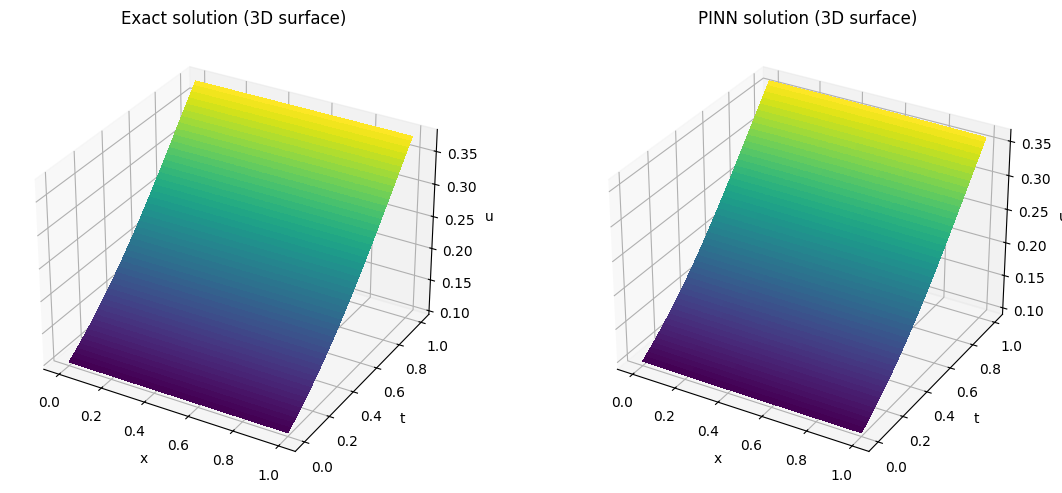

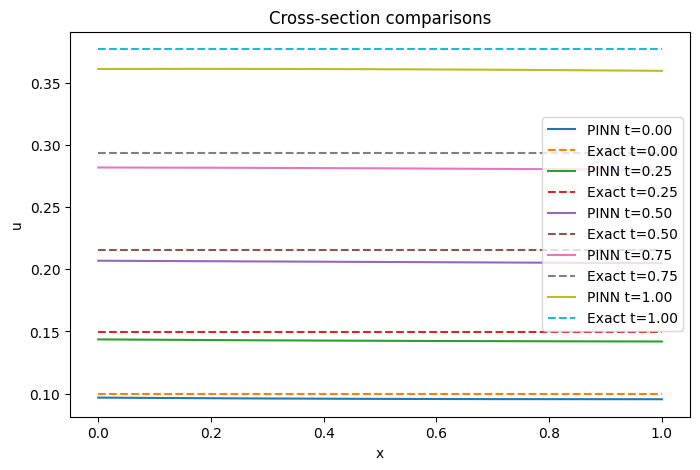

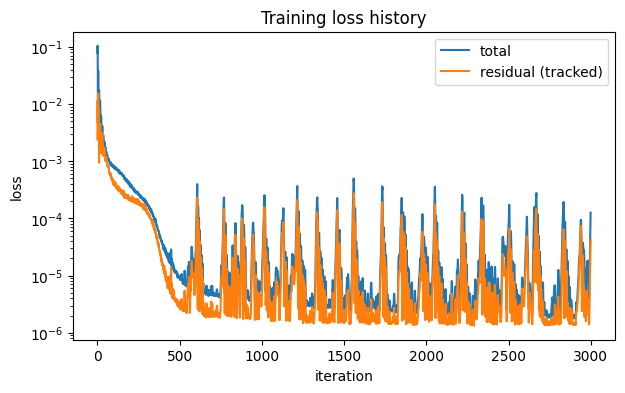

In [ ]:
# create grid
nx = 200; nt = 200
xs = np.linspace(0, Lx, nx)
ts = np.linspace(0, Tmax, nt)
Xg, Tg = np.meshgrid(xs, ts)
Xg_flat = torch.tensor(Xg.reshape(-1,1), dtype=torch.float32, device=device)
Tg_flat = torch.tensor(Tg.reshape(-1,1), dtype=torch.float32, device=device)

# model predictions
with torch.no_grad():
    U_pred_flat = model(Xg_flat, Tg_flat).cpu().numpy().reshape(nt, nx)

U_exact = exact_u(ts).reshape(nt, 1) * np.ones((1, nx))

# 3D surface: exact
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(Xg, Tg, U_exact, cmap='viridis', linewidth=0, antialiased=False)
ax.set_title("Exact solution (3D surface)")
ax.set_xlabel("x"); ax.set_ylabel("t"); ax.set_zlabel("u")

# 3D surface: PINN
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(Xg, Tg, U_pred_flat, cmap='viridis', linewidth=0, antialiased=False)
ax2.set_title("PINN solution (3D surface)")
ax2.set_xlabel("x"); ax2.set_ylabel("t"); ax2.set_zlabel("u")
plt.tight_layout()
plt.show()

# Cross-section comparison at several times
times_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]
plt.figure(figsize=(8,5))
for tt in times_to_plot:
    it = int(tt/Tmax*(nt-1))
    plt.plot(xs, U_pred_flat[it,:], linestyle='-', label=f'PINN t={tt:.2f}')
    plt.plot(xs, U_exact[it,:], linestyle='--', label=f'Exact t={tt:.2f}')
    
plt.legend()
plt.xlabel('x'); plt.ylabel('u'); plt.title('Cross-section comparisons')
plt.show()

# Loss curves
plt.figure(figsize=(7,4))
plt.semilogy(hist['total'], label='total')
plt.semilogy(hist['res'], label='residual (tracked)')
plt.xlabel('iteration'); plt.ylabel('loss'); plt.legend(); plt.title('Training loss history')
plt.show()


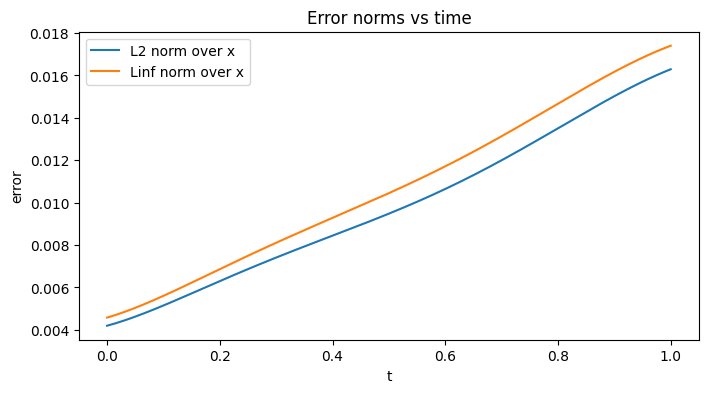

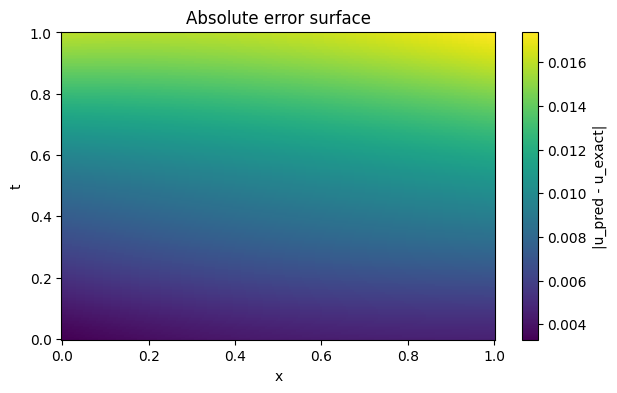

In [ ]:
# compute errors over x for each t
abs_err = np.abs(U_pred_flat - U_exact)
L2_over_t = np.sqrt(np.mean(abs_err**2, axis=1))   # discrete L2 over x
Linf_over_t = np.max(abs_err, axis=1)

plt.figure(figsize=(8,4))
plt.plot(ts, L2_over_t, label='L2 norm over x')
plt.plot(ts, Linf_over_t, label='Linf norm over x')
plt.xlabel('t'); plt.ylabel('error'); plt.legend(); plt.title('Error norms vs time')
plt.show()

# absolute error surface
plt.figure(figsize=(7,4))
plt.pcolormesh(Xg, Tg, abs_err, shading='auto')
plt.colorbar(label='|u_pred - u_exact|')
plt.xlabel('x'); plt.ylabel('t'); plt.title('Absolute error surface')
plt.show()


Warm-up run...
Ep 1/50  total=1.022e-01  res=2.698e-03  bc=8.602e-02  ic=1.352e-02
Training time (s): 0.4980475902557373

Timing experiment: Nf = 1000, epochs = 400
Ep 1/400  total=1.760e-02  res=9.612e-03  bc=4.166e-03  ic=3.820e-03
Training time (s): 3.7239973545074463
Done: Nf=1000  time=3.73s  final_loss=1.631e-04

Timing experiment: Nf = 2000, epochs = 400
Ep 1/400  total=1.405e-01  res=1.911e-02  bc=9.824e-02  ic=2.313e-02
Training time (s): 4.09126353263855
Done: Nf=2000  time=4.09s  final_loss=8.021e-05

Timing experiment: Nf = 3000, epochs = 400
Ep 1/400  total=5.689e-02  res=2.423e-02  bc=1.318e-02  ic=1.947e-02
Training time (s): 3.7920126914978027
Done: Nf=3000  time=3.79s  final_loss=1.668e-05

Timing experiment: Nf = 4000, epochs = 400
Ep 1/400  total=2.326e-02  res=4.815e-03  bc=1.471e-02  ic=3.730e-03
Training time (s): 3.9699230194091797
Done: Nf=4000  time=3.97s  final_loss=3.691e-04

Timing experiment: Nf = 5000, epochs = 400
Ep 1/400  total=2.406e-02  res=6.782e-03 

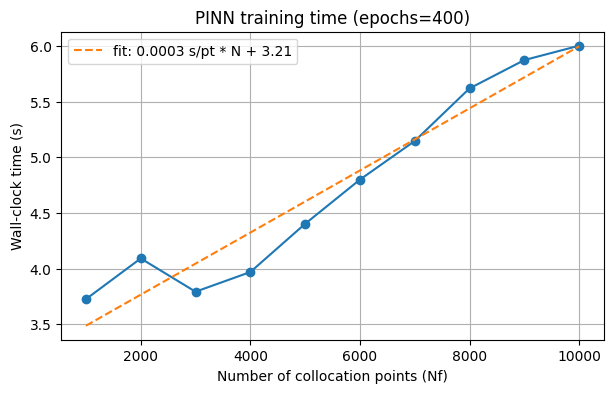

Saved results to c:\Users\Lenovo\Desktop\rand\run_results.csv


In [ ]:
import gc
import pandas as pd

Ns = list(map(int, np.linspace(1000, 10000, 20)))
# Ns = [1000, 2000]
epochs_timing = 1000
Nb_timing = 200
Ni_timing = 200
lr_timing = 3e-3

timings = []
final_losses = []
gpu = torch.cuda.is_available()

print("Warm-up run...")
_ = train_pinn(PINNNet(layers).to(device), epochs=50, Nf=500, Nb=100, Ni=100, lr=1e-3, print_every=1000)

for Nf in Ns:
    print(f"\nTiming experiment: Nf = {Nf}, epochs = {epochs_timing}")
    gc.collect()
    if gpu:
        torch.cuda.empty_cache()
    # new model for each run
    model_t = PINNNet(layers).to(device)
    t0 = time()
    hist_t = train_pinn(model_t, epochs=epochs_timing, Nf=Nf, Nb=Nb_timing, Ni=Ni_timing, lr=lr_timing, print_every=epochs_timing+1)
    t1 = time()
    wall = t1 - t0
    timings.append(wall)
    final_losses.append(hist_t['total'][-1] if len(hist_t['total'])>0 else None)
    print(f"Done: Nf={Nf}  time={wall:.2f}s  final_loss={final_losses[-1]:.3e}")

# summarize results in a dataframe and plot
df = pd.DataFrame({"Nf": Ns, "time_s": timings, "final_loss": final_losses})
print("\nResults:")
print(df)

# Plot timing vs Nf
plt.figure(figsize=(7,4))
plt.plot(df['Nf'], df['time_s'], marker='o')
plt.xlabel("Number of collocation points (Nf)")
plt.ylabel("Wall-clock time (s)")
plt.title(f"PINN training time (epochs={epochs_timing})")
# optional linear fit (to show scaling)
coeffs = np.polyfit(df['Nf'], df['time_s'], 1)
fit_line = np.poly1d(coeffs)(df['Nf'])
plt.plot(df['Nf'], fit_line, linestyle='--', label=f"fit: {coeffs[0]:.4f} s/pt * N + {coeffs[1]:.2f}")
plt.legend()
plt.grid(True)
plt.show()

import os
fn = os.path.join(os.getcwd(), "run_results.csv")
df.to_csv(fn, index=False)
print(f"Saved results to {fn}")

